<a href="https://colab.research.google.com/github/invegat/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module4-clustering/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [2]:
!pip install -U matplotlib


    100% |████████████████████████████████| 12.9MB 2.7MB/s 
    100% |████████████████████████████████| 952kB 19.5MB/s 
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
  Found existing installation: matplotlib 2.1.2
    Uninstalling matplotlib-2.1.2:
      Successfully uninstalled matplotlib-2.1.2


In [3]:
%matplotlib inline
import matplotlib
matplotlib.__version__

'3.0.2'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head()

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list) 
#df[df.title == "To Be Frank, Sinatra at 100"][0].runtime = 81
df.at[4140, 'runtime'] = 81
df.at[2656, 'runtime'] = 98

In [6]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [7]:
df_numeric.isnull().sum()

budget          0
id              0
popularity      0
revenue         0
runtime         0
vote_average    0
vote_count      0
dtype: int64

# You take it from here!

See what you can come up with. You have all the know-how! 

In [8]:
import sklearn
sklearn.__version__
print(type(num_list))

<class 'pandas.core.indexes.base.Index'>


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#dir(scaler)
df_numeric = df_numeric[(df_numeric.budget > 0) & (df_numeric.revenue > 0)]
rdf = df_numeric[['budget','revenue']].reset_index(inplace=False)
#reset = df_numeric.reset_index(inplace=False)
std = scaler.fit_transform(df_numeric)
std_df = pd.DataFrame(std, columns=num_list)
# std_df.shape

rxdf = std_df.drop(['budget','revenue'], axis=1)
rdf.tail();


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


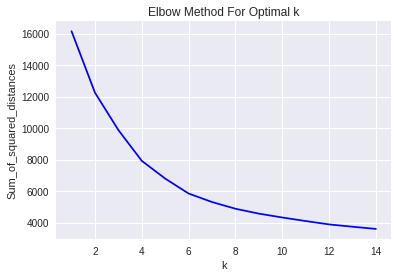

In [18]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(rxdf)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
def get_centroids(df, column_header):
  new_centroids = df.groupby(column_header).mean()
  return new_centroids
def plot_clusters(df, column_header, centroids):
  colors = {0:'red', 1:'green', 2:'yellow', 3: 'blue'}
  fig, ax = plt.subplots()
  ax.plot(centroids.iloc[0].x, centroids.iloc[0].y, "ok")
  ax.plot(centroids.iloc[1].x, centroids.iloc[1].y, "ok")
  ax.plot(centroids.iloc[2].x, centroids.iloc[2].y, "ok")
  ax.plot(centroids.iloc[3].x, centroids.iloc[3].y, "ok")  
  grouped = df.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.show()

In [0]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(rxdf)


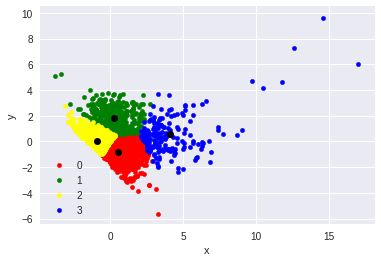

In [12]:

kmeans = KMeans(n_clusters=4)
kmeans.fit(principalComponents)
pdf = pd.DataFrame(data = principalComponents, columns = 
                   ['x', 'y'])
pdf['clusters'] = pd.Series(kmeans.labels_).values
pdf['fin_ratio'] = np.log(np.divide(rdf.revenue, rdf.budget))
centroids = get_centroids(pdf, 'clusters')
plot_clusters(pdf, 'clusters', centroids)
# print(f'min {min(pdf.fin_ratio)} max {max(pdf.fin_ratio)}')
# pdf.head()

In [13]:
hist, bin_edges = np.histogram(pdf['fin_ratio'], bins=8)
print(hist,bin_edges)

[   5    3   59 1428 1708   22    2    2] [-14.46609812 -10.66338877  -6.86067941  -3.05797006   0.7447393
   4.54744865   8.35015801  12.15286737  15.95557672]


In [0]:
def find_bin(v, edges):
  L = len(edges)
  for i,e in zip(range(L-1,-1,-1),edges[L-1::-1]):
    if v > e:
      return i
  return 0
     

In [15]:
pdf['fin_ratio_bin'] = pdf.fin_ratio.apply(lambda v: find_bin(v,bin_edges))
pdf.head()

,x,y,clusters,fin_ratio,fin_ratio_bin
0,7.711379,0.579203,3,2.465007,4
1,4.417686,-0.618969,3,1.164192,4
2,3.537591,1.786664,3,1.279430,4
3,6.284673,-0.063155,3,1.467818,4
4,0.976981,-0.061922,0,0.088782,3


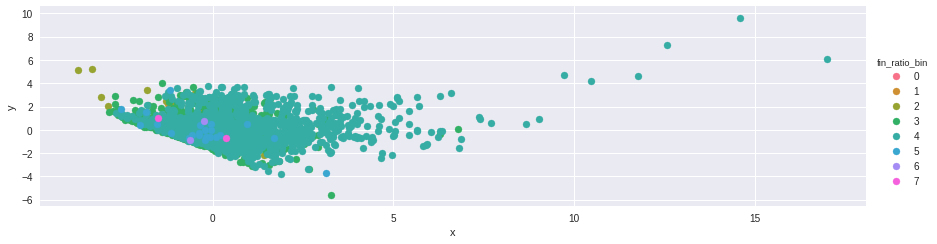

In [16]:
import seaborn
fg = seaborn.FacetGrid(data=pdf, hue='fin_ratio_bin', size = 3.5, aspect=3.5)
fg.map(plt.scatter, 'x', 'y').add_legend();

6: 320
7: 888
PCA did a good job of finding the 6s - over 320 times revenue / budget and 7s - over 888 times revenue/budget, but not on the money losers less than 4, removed budget and revenue from PCA and only used rows with nonzero budget and revenue

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.

In [14]:
langs = df.original_language.unique().tolist()
new_num_list = np.append(num_list.values,'lang')
df_numeric.shape
df.original_language.shape

(4803,)

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
if 'lang' not in df_numeric.columns:
  df_numeric['lang'] = df.original_language.apply(lambda l: langs.index(l))
std = scaler.fit_transform(df_numeric)
std_df = pd.DataFrame(std, columns=new_num_list)



/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


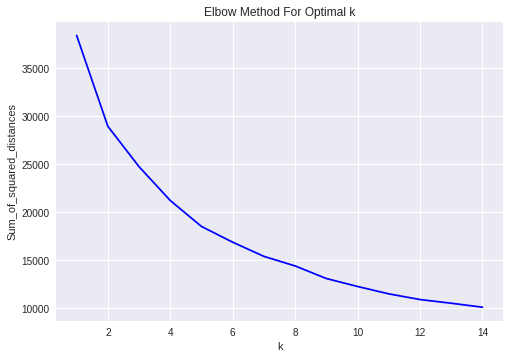

In [20]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(std_df)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(std_df)


In [0]:
def get_centroids(df, column_header):
  new_centroids = df.groupby(column_header).mean()
  return new_centroids
def plot_clusters(df, column_header, centroids):
  colors = {0:'red', 1:'green', 2:'yellow', 3: 'blue', 4: '#FFBF00', 5: '#FAEBD7', 6: '#7FFFD4', 7: '#568203'}
  fig, ax = plt.subplots()
  for i in range(len(centroids)):
     ax.plot(centroids.iloc[i].x, centroids.iloc[i].y, "ok")

  grouped = df.groupby(column_header)
  for key, group in grouped:
      group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
  plt.show()

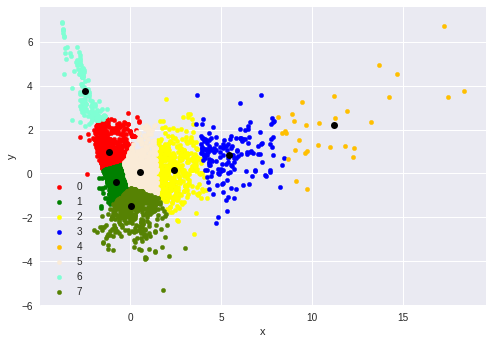

In [27]:
kmeans = KMeans(n_clusters=8)
kmeans.fit(principalComponents)
pdf = pd.DataFrame(data = principalComponents, columns = 
                   ['x', 'y'])
pdf['clusters'] = pd.Series(kmeans.labels_).values
centroids = get_centroids(pdf, 'clusters')
plot_clusters(pdf, 'clusters', centroids)